# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [2]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [5]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [6]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [7]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.4010466305154149


In [8]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


In [9]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


# 以降にコードを追加

## 前処理（標準化）

In [10]:
wine_quality_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [11]:
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(wine_quality_df[feature_names]), columns=feature_names)
scaled_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246


In [12]:
X_train, X_test, y_train, y_test = \
    train_test_split(scaled_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 特徴量選択（前向き探索）

In [13]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, feature_name, test=False):
    global X_train, X_test, y_train, y_test
    scores = cross_val_score(model, X_train[feature_name], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    loss = np.mean(scores)
    if test:
        model.fit(X_train[feature_name], y_train)
        pred = model.predict(X_test[feature_name])
        loss = mean_squared_error(y_test, pred)
    return loss

In [14]:
model = SVR(kernel="rbf")
feature_name = list()
rest_feature = feature_names.copy()
table = list()
def select_step(step):
    loss =list()
    for feature in rest_feature:
        feature_name.append(feature)
        loss.append(cross_validation(model, feature_name))
        feature_name.remove(feature)
    
    feature = rest_feature[np.argmin(loss)]
    feature_name.append(feature)
    rest_feature.remove(feature)
    test_loss = cross_validation(model, feature_name, True)
    table.append([step, test_loss, feature])
    return test_loss
loss = list(map(select_step, range(1, len(feature_names)+1)))

In [15]:
print(tabulate(table, headers=['Step', 'Loss', 'New Feature']))

Step      Loss  New Feature
------  --------  --------------------
     1  0.45943   alcohol
     2  0.462428  volatile acidity
     3  0.405999  sulphates
     4  0.395578  total sulfur dioxide
     5  0.393547  pH
     6  0.398487  fixed acidity
     7  0.385469  citric acid
     8  0.384316  density
     9  0.39217   residual sugar
    10  0.39189   chlorides
    11  0.387759  free sulfur dioxide


Text(0.5, 1.0, 'Loss Transition')

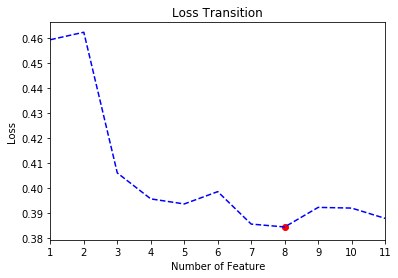

In [16]:
plt.plot(np.arange(1, len(loss)+1), loss, c='b', ls='--')
plt.scatter(np.argmin(loss)+1, np.min(loss), c='r')
plt.xticks(range(1,len(loss)+1))
plt.xlim(1,len(loss))
plt.xlabel('Number of Feature')
plt.ylabel('Loss')
plt.title('Loss Transition')

## テストスコアの向上
ただ整理しただけです.

In [17]:
def preprocess(df):
    feature_names = list(np.copy(df.columns))
    rm_names = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'quality']
    [feature_names.remove(re_name) for re_name in rm_names]
    ss = StandardScaler()
    X = ss.fit_transform(df[feature_names])
    y = df['quality'].values
    return X, y

def cross_validation(X, y, model):
    kfold = KFold(n_splits=5, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('Test score: {}'.format(mean_squared_error(y_test, pred)))

def main():
    wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
    X, y = preprocess(wine_quality_df)
    model = SVR(kernel="rbf")
    cross_validation(X, y, model)

In [18]:
main()

Cross-Validation scores: [0.44275481 0.42219037 0.3870712  0.41350361 0.34471098]
Average score: 0.4020461964747096
Test score: 0.384315510810904
